In [251]:
import numpy as np 
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scienceplots 
plt.style.use(['science', 'grid', 'retro'])

In [ ]:
class TransportCoefficients:
    def __init__(self, D, S, V):
        self.D = D # np.empty_like(x) # calcD(DIN, x)
        self.S = S # np.empty_like(x)
        self.V = V # np.empyt_like(x)

class Boundaries: 
    def __init__(self, FluxIn, u_edge): 
        self.fluxin = FluxIn 
        self.u_edge = u_edge

def pedestal_ode(x, u, coeffs: TransportCoefficients,  bcs:Boundaries):
    dudx = np.gradient(u, x)
    dudx[0] = (bcs.fluxin - coeffs.V[0]*u[0])/coeffs.D[0] # I DON'T THINK THIS IS CORRECT
    dudx[-1] = (u[-1] - u[-2])/(x[-1] - x[-2])

    flux = coeffs.D * dudx + coeffs.V * u
    flux[0] = bcs.fluxin

    dudt = np.gradient(flux, x) + coeffs.S
    dudt[0] = (flux[1] - flux[0]) / (x[1] - x[0]) # IS THIS NECSESARY?
    dudt[-1] = 0.0
    return dudt

def solve_pde(x, u0, coef, bcs, tinterval: list[float]): 
    ode_to_handle = lambda t, y: pedestal_ode(x, y, coef, bcs)
    sol = solve_ivp(ode_to_handle, tinterval, u0, method='RK45', rtol=1E-5)
    return sol.y# [:, -1]

def mtanh(r,h1, h0, s, p, w ): 
    # h1, h0, s, p, w = ped height, offset, slope, position, width\n",
    x = (p - r) / (w / 2.0)
    return (h1 - h0) / 2.0 * ( ((1 + s*x)*np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)) + 1) + h0

norm_pdf = lambda _x, mu, sigma: (1.0 / np.sqrt(np.pi*2*sigma**2)) * np.exp(-(_x-mu)**2 / (2*sigma**2))

We want to make a inter-elm cycle such that the solution, u, resembles a MTANH curve fit (i.e., max pedestal). This would likely require us to find du/dt = 0, and thus the transport coefficients that the RHS are 0 for the MTANH curve. 



In [3]:
intra_elm_duration = 200*0.000001 # s or 200 us
f_elm = 20 # Hz
inter_elm_duration = 1/f_elm - intra_elm_duration


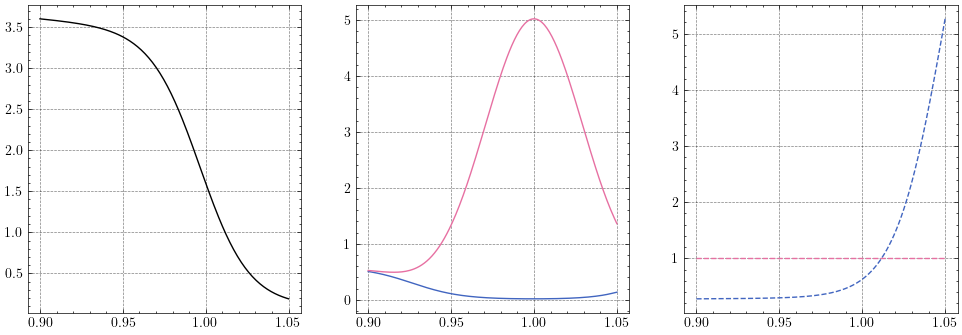

In [265]:
NX = 200
prof_height, prof_slope, prof_position, prof_width = 3.4419810747067103,0.030139759552640658,0.9969544671849752,0.05960778316391867 # 2.77015220953408,0.10856566193018946,1.0121382125850138,0.14214093301620753

# Flux in can be non-zero
fluxin = - prof_height / 4.0 
u_edge = 0.0
bcs = Boundaries(fluxin, u_edge)

x = np.linspace(0.9, 1.05, NX)

u0 = mtanh(x, prof_height, u_edge, prof_slope, prof_position ,prof_width)  
du0dx = np.gradient(u0, x)
S = np.zeros(NX)
D_2 = abs(1.0 / du0dx)
V_2 = 1.0 / u0
coeffs_2 = TransportCoefficients(D_2, S, V_2)

V_4 = np.ones(NX)
# V_4[x>1.0] = prof_height
example_d = norm_pdf(x, 1.0, prof_width / 2.0)
D_4 = (example_d / (2.0*max(example_d)))*10.0 + D_2 
coeffs_4 = TransportCoefficients(D_4, S, V_4)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
axs[0].plot(x, u0, label='Initial Condition', color='black')
for n, _coef in enumerate([coeffs_2, coeffs_4]):
    axs[1].plot(x, _coef.D, label='D(x)')
    axs[2].plot(x, _coef.V, label='V(x)', ls='--')
plt.show()

1 1.737050046752343
2 1.3941899969458496


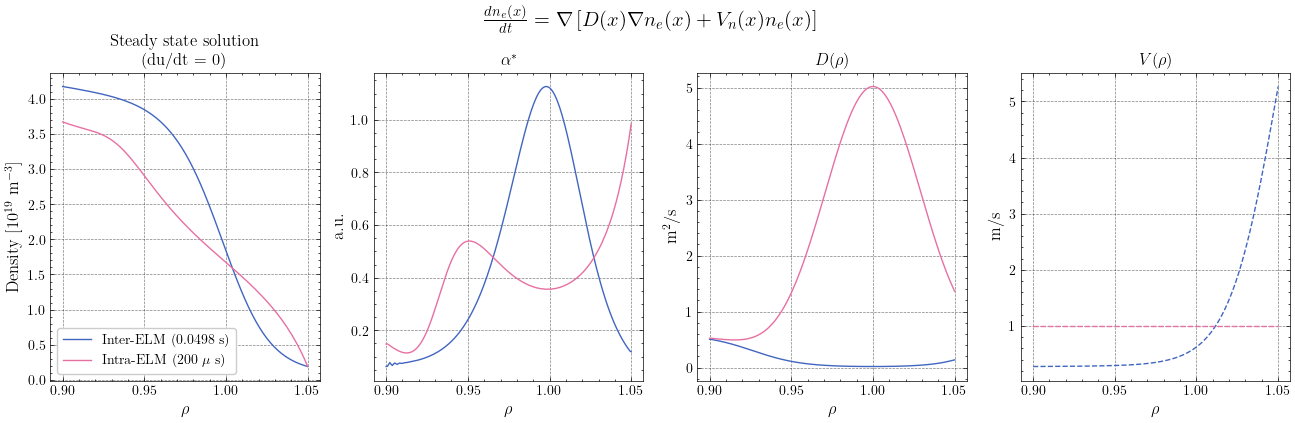

In [266]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharex=True)
alpha_crit = max(abs(np.gradient(u0, x)))
labels = [f'Inter-ELM ({inter_elm_duration:.3} s)', r'Intra-ELM (200 $\mu$ s)', None]
index_sep = np.argmin(abs(x - (prof_position)))
index_ped = np.argmin(abs(x - (prof_position - prof_width/2.0)))

for n, _coef in enumerate([coeffs_2, coeffs_4]):
    if n in [0]: 
        time_duration = inter_elm_duration 
    else: 
        time_duration = intra_elm_duration
    if n in [0]: 
        starter_u0 = u0
    else: 
        start_u = sol

    sols = solve_pde(x, starter_u0, _coef, bcs, [0.0, time_duration])
    sol = sols[:, -1]
    axs[0].plot(x, sol, label=labels[n])
    axs[2].plot(x, _coef.D, label='D(x)')
    axs[3].plot(x, _coef.V, label='V(x)', ls='--')
    print(n+1, sol[index_ped] / sol[index_sep])
    axs[1].plot(x, abs(np.gradient(sol, x))/ alpha_crit)


axs[0].legend()
axs[0].set_title('Steady state solution \n(du/dt = 0)', fontsize=12)
axs[0].set_ylabel(r'Density $[10^{19}$ m$^{-3}$]', fontsize=12)
axs[1].set_ylabel(r'a.u.', fontsize=12)
axs[2].set_ylabel('m$^{2}$/s', fontsize=12)
axs[3].set_ylabel('m/s', fontsize=12)
axs[1].set_title(r'$\alpha^*$', fontsize=12)
axs[2].set_title(r'$D(\rho)$', fontsize=12)
axs[3].set_title(r'$V(\rho)$', fontsize=12)
fig.suptitle(r'$\frac{d n_e(x)}{dt} = \nabla \left[D(x) \nabla n_e(x) + V_n(x) n_e(x)  \right]$', y=1.05, fontsize=15)
for ax in axs: 
    ax.set_xlabel(r'$\rho$', fontsize=12)
# fig.savefig('./solutions-for-various-coefficients', dpi=300)
plt.show()



In [236]:
u0 = mtanh(x, prof_height, u_edge, prof_slope, prof_position ,prof_width)   # np.linspace(2, 1, NX)
index_sep = np.argmin(abs(x - (prof_position)))
index_ped = np.argmin(abs(x - (prof_position - prof_width/2.0)))

alpha_crit =  max(abs(np.gradient(u0, x)))

t0 = 0.0
# starting time and coefficients
_coef = coeffs_2
times = [t0]
total_solution = [u0]

total_time = 1.0 # (inter_elm_duration + intra_elm_duration)*5
num_tsteps = 5000 
for iteration in range(1, num_tsteps):
    t1 = iteration*total_time / num_tsteps
    sols = solve_pde(x, u0, _coef, bcs, [t0, t1])
    sol = sols[:, -1]
    total_solution.append(sol)
    u0 = sol
    
    alpha_exp = np.max(abs(np.gradient(u0, x)))
    if (alpha_exp / alpha_crit > 1.05): 
        # now in ELM pahse
        _coef = coeffs_4
        
    elif (alpha_exp / alpha_crit < 0.8): 
        _coef = coeffs_2

    t0 = t1
    times.append(t0)
times = np.array(times)
total_solution = np.stack(total_solution)

In [256]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib
from matplotlib.colors import Normalize

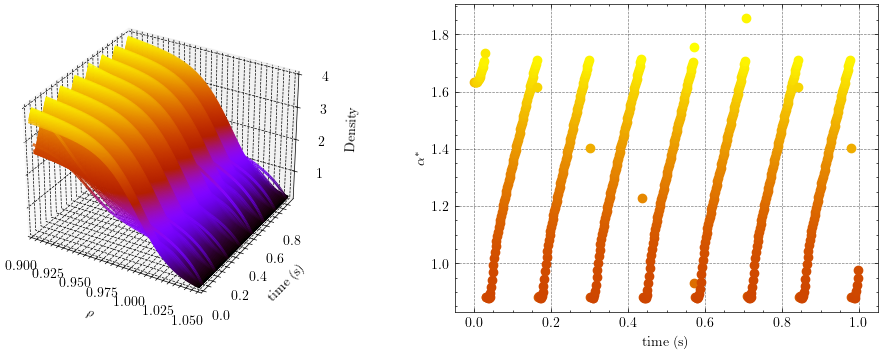

In [257]:
fig = plt.figure(figsize=(12, 4))
dax = fig.add_subplot(121, projection='3d')
alphaax = fig.add_subplot(122)


norm = Normalize(vmin=np.min(total_solution), vmax=np.max(total_solution))
cmap = matplotlib.colormaps.get_cmap('gnuplot')

segments = []
colors = []

# Loop over time steps and create line segments with color mapping
for tidx, t in enumerate(times):
    if tidx % 10 != 0 and tidx != 0:
        continue
    timearray = np.ones_like(x) * t
    z_values = total_solution[tidx]

    alpha_exp = np.max(abs(np.gradient(z_values, x)))
    color = cmap(z_values[0] / max(total_solution[:, 0]))
    alphaax.scatter(t, alpha_exp / alpha_crit, color=color)

    # Create line segments for each time slice
    points = np.array([x, timearray, z_values]).T.reshape(-1, 1, 3)
    segs = np.concatenate([points[:-1], points[1:]], axis=1)
    segments.extend(segs)

    # Map z-values to colors
    segment_colors = cmap(norm(z_values))
    colors.extend(segment_colors[:-1])

# Sort segments and colors by the average z-value of each segment
avg_z_values = [np.mean(seg[:, 2]) for seg in segments]
sorted_indices = np.argsort(avg_z_values)

sorted_segments = [segments[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

# Create a Line3DCollection from the sorted segments and colors
lc = Line3DCollection(sorted_segments, colors=sorted_colors, linewidth=2)

# Add the collection to the plot
dax.add_collection(lc)

# Set the limits for the axes
dax.set_xlim(np.min(x), np.max(x))
dax.set_ylim(np.min(times), np.max(times))
dax.set_zlim(np.min(total_solution), np.max(total_solution))
dax.set_xlabel(r'$\rho$')
dax.set_ylabel('time (s)')
dax.set_zlabel('Density')
alphaax.set_xlabel('time (s)')
alphaax.set_ylabel(r'$\alpha^*$')
plt.savefig('shitty-pedestal-evolution.png', dpi=300)
plt.show()
